# Customer review timeline (of Sea Temple Port Douglas)

## TLDR:

I explore the current trends of `customer experience` through online comments on TripAdvisor for Pullman Sea temple (PPD) in Port Douglas, Queensland, Australia.

By analysing the scores, I discovered:
- The [score distribution by comments](#how-scores-distribute). Most comments have a high score (5 bubbles/stars)!

However, when applying a `Time series analysis` I realised that:
- [Monthly average number of comments](#timeseries) has increased through the years, although
- [Score evolution](#score-through-time) shows a declining trend in recient years, and
- when counting the proportion of comments, I dicovered that despite most comments are still positive, negatives are growing

To undertand the customer experience and why the score are declining, I performed several `Text analysis` of the actual comments, to discover:
- By using multiple strategies I extrated [most common phases](#the-comments) to see which factors are the most important for customers, like the swimming pool, the distance to town or the staff
- Applying `vector similarity`, I build a [semi-supervised sentence classifier](#semi-supervised-classification-of-text) to group the text by its content in 5 categories: Housekeeping, Infrastructure, Restaurant, Front Desk and other. I later checked if their prevalence changed through time. Which wasn't the case.
- Also, I used full unsupervised [Topic modelling technique](#other-way-to-classify-reviews-lda) to explore more relevant topics I could miss in the first analysis.
- Then, I applied [Sentiment Analysis](#sentiment-analysis), to score how positive or negative a comment was by its content, and realised that Housekeeping has the most negative sentiment because it was higly impacted by high demand periods. 
- Finally, I validated the result with the associated score to the sentence.


---
## Context

I'm travelling throughout Australia with a WH visa. I wanted to apply for an extension of my visa. Then, to do so, I have to work either in hospitality or farm for 88 days north of the tropic. I have experience in both farms (picking fruit in New Zealand in a WH as well) and tourism (in Chile as [data] consultant), but this is not New Zealand, here there are lots of deadly animals everywhere. I’d rather work inside a Resort than in the countryside. So, I moved to Port Douglas, a very touristic hot spot.

The work is nice as a housekeeper, but I miss my analytics. Of course, before I came, I wanted to know "who is who" in this touristic hub in northern Queensland, which is close to the Daintree rainforest and one of the best spots to see the giant coral reef. 

I knew the major players and I checked their commentaries on TripAdvisor. Later, talking to one of the supervisors about customer reviews, I was taught the metrics of quality they hold. It seems none of the metrics considered the text -which is my specialization- to build a systematic review through time (I mean, they read  thoughtfully and have some insights how comments vary through time, but not a systematic indicator, let say a number over text or some other pattern).

I think it is time to apply some analytics to text review the TripAdvisor reviews. I updated my webscraping script to get the data (1880 English reviews) and is time to  play.

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt
plt.rcParams["figure.figsize"] = [15, 7]
import scipy.stats as stats
from __future__ import unicode_literals
plt.style.use(['dark_background'])

In [3]:
data = pd.read_csv('./tripullman/test.csv', encoding= "utf-8")
print(data.shape)
# Let's use english names in columns for clarity
data.columns = ['n_opinions', 'level', 'about', 'author','score', 'about_score', 'comment', 'address', 'date', 
'location','name', 'region', 'type','type1', 'title', 'link']

(1880, 16)


In [4]:
data.head(3)

,n_opinions,level,about,author,score,about_score,comment,address,date,location,name,region,type,type1,title,link
0,"1,915 reviews",6,Pullman Port Douglas Sea Temple Resort & Spa,Neil O,30,4.5,5 star prices and 3 star service. We stayed in...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",14 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",First family holiday,https://www.tripadvisor.com.au/Hotel_Review-g2...
1,"1,915 reviews",7,Pullman Port Douglas Sea Temple Resort & Spa,Daniel L,50,4.5,We have stayed now 2 times. The staff have alw...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",2 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",The best hotel in port Douglas,https://www.tripadvisor.com.au/Hotel_Review-g2...
2,"1,915 reviews",1,Pullman Port Douglas Sea Temple Resort & Spa,Carrie G,20,4.5,My family and I recently stayed for 5 nights a...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",5 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",Not deserving of 5 star rating,https://www.tripadvisor.com.au/Hotel_Review-g2...


In [5]:
# tidy calification scores
data.score = data.score/10

## How scores distribute

TripAdvisor has a system of bubbles (or Stars) ranking from 1 to 5. In that respect, most reviews give 5 bubbles to the resort with more than 1000 high score reviews (more than half of reviews).

In [6]:
data.score.describe()

count    1880.000000
mean        4.261170
std         0.986002
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: score, dtype: float64

<AxesSubplot:title={'center':'PPDR Stars distribution'}, xlabel='Scores', ylabel='# of comments'>

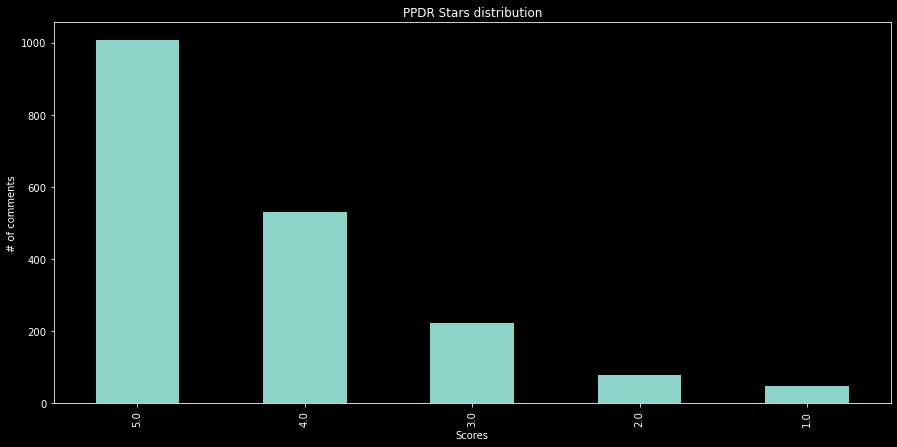

In [7]:
data.score.value_counts().plot(kind='bar', title='PPDR Stars distribution', ylabel='# of comments', xlabel='Scores')

## Timeseries
 
First, let's see how many commentaries the resort has monthly.

In [8]:
data['date2'] = pd.to_datetime(data.date, format='%d %B %Y')
dfd = data.copy()
dfd.set_index(pd.DatetimeIndex(dfd['date2']), inplace=True)
dfd = dfd.sort_index()

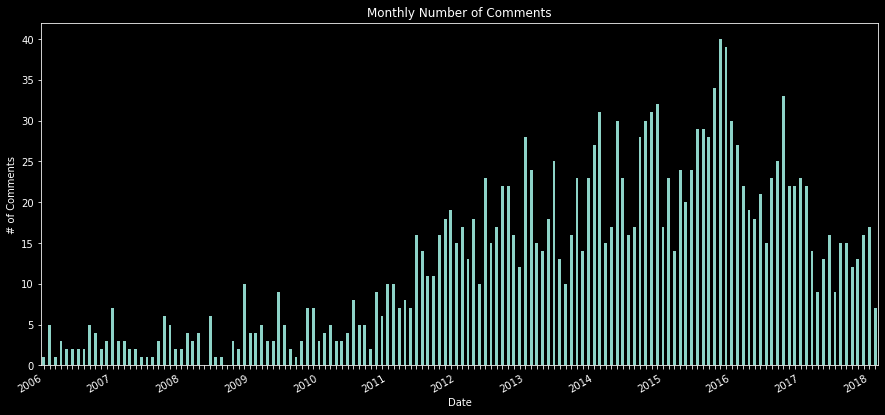

In [9]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

bar_chart = dfd.score.copy()
bar_chart = bar_chart.resample(rule='M').count()
ax = bar_chart.plot(kind='bar', x = bar_chart.index)

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = [''] * len(bar_chart.index)
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%Y') for item in bar_chart.index[::12]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_title('Monthly Number of Comments')
ax.set_ylabel('# of Comments')
ax.set_xlabel('Date')
plt.pyplot.gcf().autofmt_xdate()
plt.pyplot.show()

OK. So since 2012 comments are 20 each month, reaching a pick in 2017 up to 40 comments in a single month.

### Score through time

Let's calculate the score average for every month.

<AxesSubplot:title={'center':'Monthly Average Score'}, xlabel='Date', ylabel='Score'>

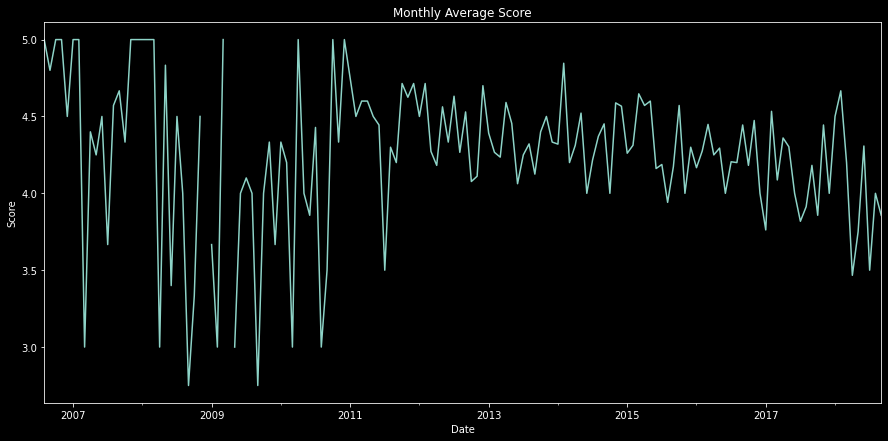

In [10]:
linear = dfd.score.copy()
linear = linear.resample(rule='M').mean()
linear.plot(kind='line', title='Monthly Average Score', ylabel='Score', xlabel='Date')

It seems that before 2012 -when there is few comments- the mean is quite volatile, but then moves aroud 4.5 and its been slighly decreasing. More stable number could be the accumulate version.

<AxesSubplot:title={'center':'Accumulative average score'}, xlabel='Date', ylabel='score'>

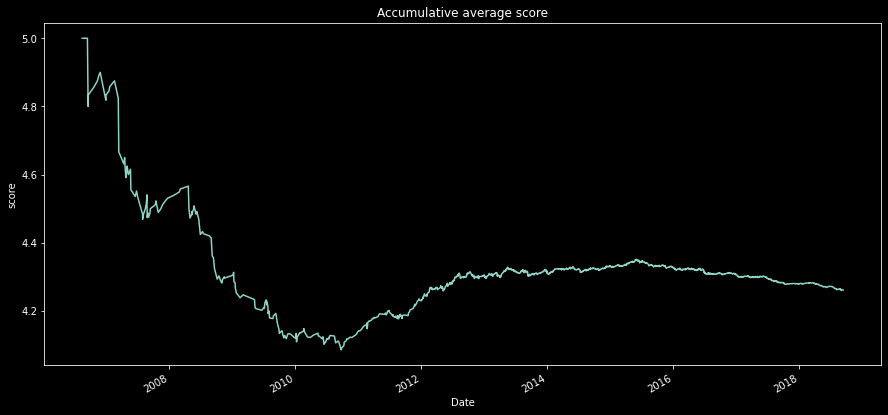

In [11]:
dfd.score.expanding().mean().plot(title='Accumulative average score', ylabel='score', xlabel='Date')

The mean becomes more stable as more reviews are added, therefore, to change a reputation over time requires a lot of comments of the opposite sign. It means that the initial good reputation was easily lowered at the beginning by a few bad comments but then reverse easily as well. But then, when it reaches a plateau, change is more subtle. So, the slight decrease, in the end, could be hiding something.

Let's see the distribution of reviews over time if we normalize the number of reviews. Just take data from 2014 and on to take the initial noise out.

C:\Users\framo\AppData\Local\Temp/ipykernel_21360/3871187192.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  calification = calification.drop('total', 1) #erase total column


<AxesSubplot:title={'center':'Monthly proportion of comments by score'}, xlabel='Date', ylabel='% of comments'>

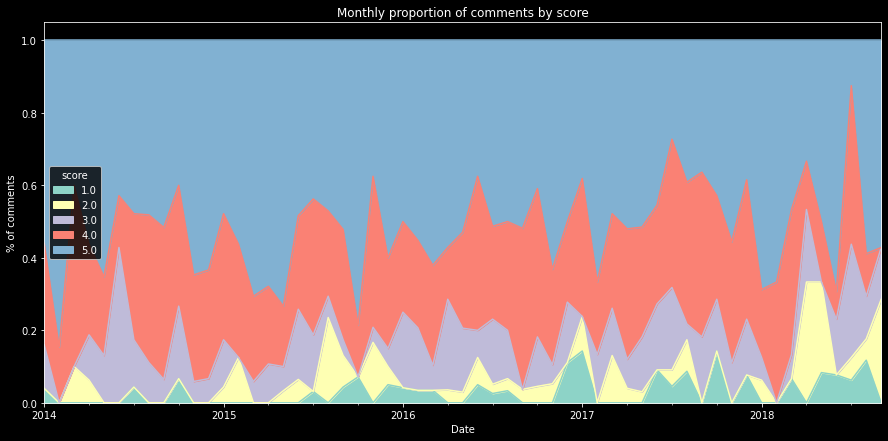

In [12]:
calification = pd.crosstab(dfd.date2, dfd.score)
calification = calification.resample(rule='M').sum()
calification['total'] = calification.sum(axis=1) # calculate a horizontal sum as total
calification = calification.div(calification.total, 0) # divide each column again total column
calification = calification.drop('total', 1) #erase total column
#calification=pd.concat([calification], keys=calification.index.year, names=['ano'])
calification.loc['2014':,:].plot(kind='area', ylabel="% of comments", xlabel='Date', title= "Monthly proportion of comments by score")
#calification.head()

It seems that the last year scores lower than 3 are more common than before. What if we compare year after year.

<AxesSubplot:title={'center':'Year 2018'}, xlabel='date2'>

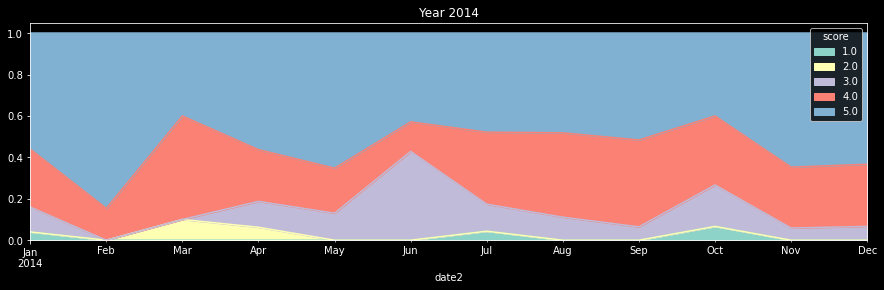

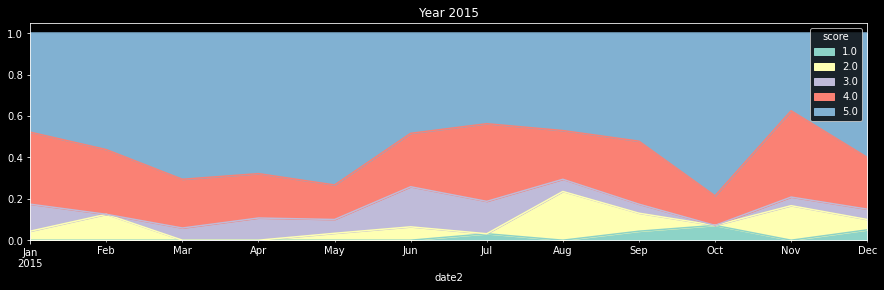

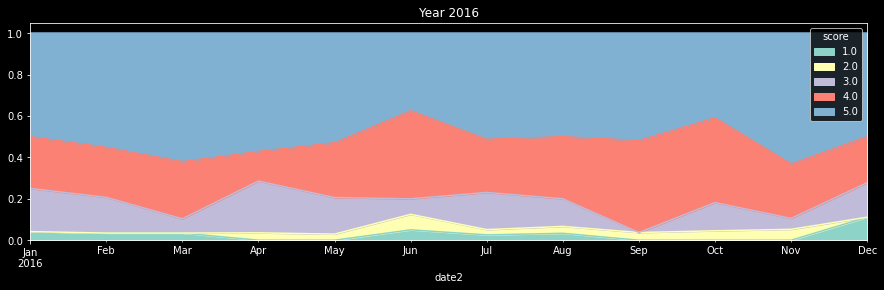

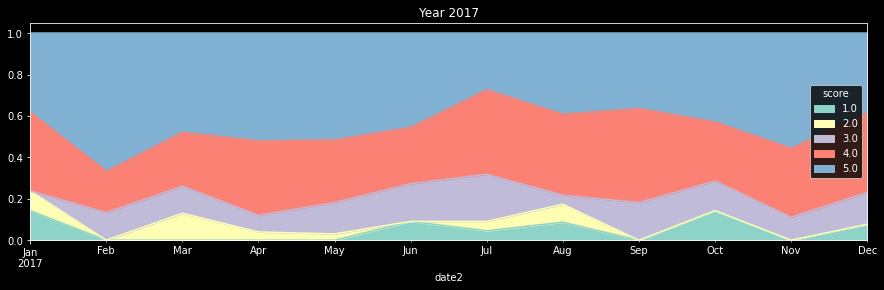

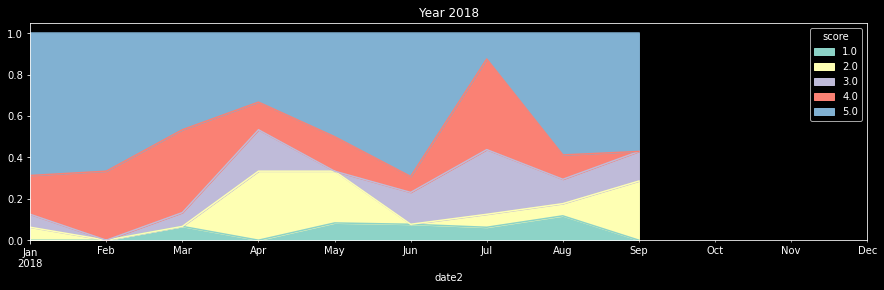

In [13]:
years = map(str, calification.index.year.unique()[8:].tolist())
years = [*years]
for year, i in zip(years[:-1], range(len(years)-1)):
    calification.loc[year:year,:].plot(kind='area',figsize=(15,4),sharex=True, title="Year {}".format(year))
calification.loc['2018':'2018',:].plot(kind='area',figsize=(15,4),xlim=(pd.Timestamp('2018-01-31 00:00:00', tz=None),
pd.Timestamp('2018-12-01 00:00:00', tz=None)), title="Year {}".format('2018'))

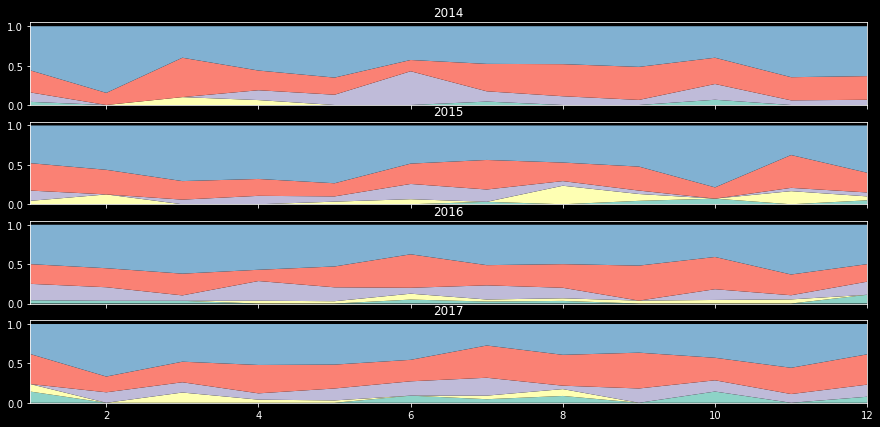

In [14]:
# Just for practice. Can I put all years in a single multi-plot?
from matplotlib import dates
fig, ax = plt.pyplot.subplots(4, 1, sharex='col', sharey='row')
years = map(str, calification.index.year.unique()[8:].tolist())
years = [*years]
x_dates = calification.index.month.sort_values().unique()
for year, i in zip(years[:-1], range(len(years)-1)):
    c=calification.loc[year:year,:]
    ax[i].stackplot(c.index.month,c[c.columns[0]],c[c.columns[1]],c[c.columns[2]],c[c.columns[3]],c[c.columns[4]])
    #ax[i].xaxis_date()
    #ax[i].xaxis.set_major_formatter(plt.pyplot.FixedFormatter(x_dates))
    #ax[i].xaxis.set_major_formatter(dates.DateFormatter('\n%b'))
    ax[i].set_xlim(1,12)
    ax[i].set_title(year)
    #ax[i].

In the last year there are more negatives comments. Something not good is happening.

## The Comments

Despite previous observations, many reviews are generally positive, but they refer to different things. To make things clearer let's split the reviews into sentences. That way we could note the difference if a comment is about more than one subject.

### Prepare text data and split reviews into sentences

In [15]:
from nltk.tokenize import word_tokenize, sent_tokenize

data_sentence = data[['title','score','comment','date']].copy()
data_sentence.dropna(subset = ['comment'], inplace=True)
data_sentence['sentence'] = data_sentence.comment.apply(sent_tokenize)
data_sentence = (data_sentence['sentence'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True).to_frame('sentence').join(data_sentence[['title','score','comment','date']], how='left'))

Check the new data set with a sentence by row.

In [16]:
data_sentence.reset_index(drop=True, inplace=True)
data_sentence.head()

,sentence,title,score,comment,date
0,5 star prices and 3 star service.,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
1,We stayed in a villa with a private pool which...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
2,The maintenance man even said it’s so hard to ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
3,The food is bang average not just at the hotel...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
4,The staff are all great and try and make your ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018


## Look for meaning (most significative bi-grams)

#### Extract most common bi-grams and tri-grams

To explore the content first I could have a look of the most frequent words. A simple model of sklearn can give us that information. Let’s see some bi-grams and tri-grams.

In [17]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

stp = nltk.corpus.stopwords.words('English') 
data_sentence.sentence.dropna(inplace=True)

vectorizer = TfidfVectorizer(lowercase=True, stop_words=stp[:130] ,ngram_range = (2,3), min_df=5).fit(data_sentence.sentence)
full_matrix = vectorizer.transform(data_sentence.sentence)


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 're', 've'] not in stop_words.
  warnings.warn(


In [18]:
def display_scores(vectorizer, tfidf_result,n=50):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names_out(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores[:n]:
        print("{0:50} Score: {1}".format(item[0], item[1]))
        
display_scores(vectorizer,full_matrix,25)

sea temple                                         Score: 189.90169447722204
port douglas                                       Score: 182.21243902619142
pool bar                                           Score: 69.29847448091986
staff friendly                                     Score: 65.5138027376518
stayed nights                                      Score: 51.820851519108004
room service                                       Score: 51.07599969858622
pool area                                          Score: 48.87967481590824
lagoon pool                                        Score: 44.75179774602524
front desk                                         Score: 43.37761076592198
golf course                                        Score: 42.37498411886369
plunge pool                                        Score: 41.55567496675205
friendly helpful                                   Score: 38.634722321888624
two bedroom                                        Score: 36.10181404189697
swimming 

This is the most frequent combination of words in the reviews. It doesn't seem to be very meaningful. But we can collect some insights. So, besides the name of the resort, the pool and the staff are definitely the most common words (and let me tell you, the pool is upstanding), and must be a very important part of the customer experience. Let's try another technique to get more information.

### Detect keyphases

We can improve the detection of n-grams. It not only will help to create keyphases to identify the text but also will improve the understanding of the text itself.

##### Keyphrases with bigrams

In [19]:
import nltk
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from collections import Counter

data_words = [i for i in data_sentence.sentence]
#data_words = data_sentence.sentence.apply(word_tokenize)
data_words = [simple_preprocess(i, deacc=True) for i in data_words]
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


Now we check how one sentence looks once we created the n-grams.

In [20]:
print(trigram_mod[bigram_mod[data_words[632]]])

['me', 'and', 'my', 'husband', 'visited', 'port_douglas', 'for', 'short', 'stay', 'and', 'booked', 'an', 'accomodation', 'at', 'pullman', 'sea_temple', 'port_douglas']


Seems to work. Now I can clean the sentences and apply the ngram model it to the whole corpus.

In [21]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stp] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

text = remove_stopwords(data_words)
text = make_bigrams(text)
text = make_trigrams(text)

In [22]:
# Let's replace the sentences with the trigams and bigrams
data_sentence.sentence = text
data_sentence.sentence = data_sentence.sentence.apply(' '.join)

People are astonished by the direct access to the pool. As we see previously the pool is one of the most common words in reviews. It is quite an impressive pool. I would bet is the main selling factor. Since we have some "new words" created on n-grams let’s try to check if I can create some keyphrases. For that, I will use word2Vec or word embeddings, that in theory would help to find synonymous to those phrases.

In [23]:
from gensim.models import Word2Vec

bigram_model = Word2Vec(bigram_mod[data_words])
bigram_model_counter = Counter()
for key in bigram_model.wv.vocab.keys():
    if key not in stp:
        if len(key.split("_")) > 1:
            bigram_model_counter[key] += bigram_model.wv.vocab[key].count

In [24]:
for key, counts in bigram_model_counter.most_common(30):
    print('{0} \t {1}'.format(key.encode("utf-8"), counts))

b'sea_temple' 	 523
b'port_douglas' 	 512
b'front_desk' 	 74
b'golf_course' 	 67
b'highly_recommend' 	 56
b'roof_top' 	 56
b'shuttle_bus' 	 52
b'well_appointed' 	 47
b'hot_tub' 	 40
b'direct_access' 	 35
b'ground_floor' 	 34
b'barrier_reef' 	 30
b'mile_beach' 	 29
b'school_holidays' 	 29
b'wedding_anniversary' 	 28
b'palm_cove' 	 26
b'five_star' 	 26
b'hire_car' 	 25
b'minute_drive' 	 24
b'four_mile' 	 23
b'ended_up' 	 22
b'washer_dryer' 	 21
b'spiral_staircase' 	 21
b'main_street' 	 20
b've_ever' 	 20
b'young_children' 	 19
b'per_person' 	 19
b'make_sure' 	 19
b'self_contained' 	 18
b'washing_machine' 	 18


Now it looks like we can found some meaning on them. Let's check some interesting ones within context. Because we are only focusing in a sentence within a whole text, let's highlight the sentence words in red.

In [25]:
pd.set_option('display.max_colwidth', None)

from IPython.display import display, Markdown, Latex, HTML

def highlight_selected_text(row):
    text = row["comment"]
    ext = row["sentence"]
    color = {" " + v.replace("_"," "):'red' for v in ext.split(' ')}
    #print(color)
    for k, v in color.items():
        text = text.replace(k, f'<span style="color: {v}; font-weight: bold">{k}</span>')

    return text


In [26]:
display(HTML(data_sentence[['sentence','comment']][data_sentence.sentence.str.contains("front_desk")].sample(3).apply(highlight_selected_text, axis=1).to_frame().to_html(escape=False)))

,0
3526,"We were really looking forward to staying here, based on the photos on line, but it was a big disappointment. We arrived late on Christmas Eve after a long flight and long day. We booked three studio spa rooms months ago, and requested adjoining rooms for us and our two kids. Not only did the rooms not adjoin, they weren't even in the same building (they were in the next building over). As a result, I asked about changing to a 3 bedroom villa (same price). The front desk person told us it was available, but she could not make this change, so we had to wait for the manager. He then told us the villa was not available and when I asked about a 2 bedroom villa, he said there was one available but it was not clean. We stayed with the rooms we had. The rooms are in need of some serious updating. The shower stall was covered in mold and pretty disgusting. The floors were dirty as we found out after walking around barefoot then putting our feet on the bed and seeing dirt all over the white bedspread. After that, we made sure to wipe our feet thoroughly before getting into bed. The white blanket I pulled from the closet was covered in brown and yellow stains."
3477,"This beautiful place made our family holiday very enjoyable. Service was excellent from Front Desk to Housekeeping staff and groundsmen. Special mention to Kate, Assistant Manager who made our stay extra special by surprising us with wine and cheese platter for our wedding anniversary. She even helped us with our daily itinerary. Mossman Gorge is a must to visit where you can swim in the refreshing water of the river. We had the 2 bedroom apartment with a private plunge pool so we enjoyed the night dipping in the privacy of our own backyard. The rooms are spacious. Beds are very comfy and the kitchen provides everything you need to prepare meals for the family. There is washer and dryer which we used every night to avoid pile of laundry. On our last night, we went to Macrossan St where we found variety of different restaurants. and we decided to save the cooking and had our dinner there. The street is just 10 minute drive away from Pullman. This holiday has been one of the top holidays we had. We will definitely return."
5407,"Right from the time we made our booking direct with sea temple we new we would have a memorable holiday .We as a family booked two beach side 3 brm villas for two weeks . Just amazing . The villas were very well appointed and spacious allowing us as a family to be able to enjoy our holiday in a relaxed and very comfortable accom . The villas had there own plunge pool which considering it was the end of Aug we were able to swim in . The villas have there own BBQ and again we used these on a number of occasions . The BBQ was cleaned and checked every day . We all enjoyed the main pool along with the helpful staff at the pool bar . Great service here when ordering a bite to eat. As a adult family of 10 we at different times experienced the Aqua restaurant for breakfast ,lunch and a formal dinner . All of the family really enjoyed the meals and service we received . The front desk again very helpful from the moment we checked in. Booking golf at the palmer sea reef course and a few tours were no problem to them . This is a classy and well managed resort with wonderful and very helpful staff right from the reservation staff to all the housekeeping and maintenance staff . Well done sea temple ... we will be back"


It seems that the guys at frond desk are doing a great job. 

In [27]:
display(HTML(data_sentence[['sentence','comment']][data_sentence.sentence.str.contains("shuttle_bus")].sample(3).apply(highlight_selected_text, axis=1).to_frame().to_html(escape=False)))

,0
2814,"A group of us stayed in a 2 bedroom apartment , it was very roomy, very airy, there was a bbq area upstairs with a spa , had everything you would want for a relaxing weekend this time of the year it is not very busy . The complex has swimming pools and the local area has golf courses for the avid golf player. The local shops are about 5 minutes away the resort has a shuttle bus which can be used to go the shops if necessary"
2485,"Travelled to Port Douglas with teenagers, the Pullman has a wonderful pool and is about a 1 hour walk into Port Douglas along the beach. Stayed for 6 days and used shuttle bus to get into Port Douglas which was quite good and easy, make sure you organise a suitable pass otherwise you will be paying for each trip! Pullman had quite alot of very young kids (not well supervised) there was a lot of morning noise, particularly if you get a swim out pool room which is what we had. Staff were lovely and room staff were particularly helpful."
3033,Took my partner here for his birthday. We were delighted with a complimentary bottle of bubbly wine. Beautiful resort. Lovely pool. We stayed in the Spa room. Very spacious room and spa. Reasonable price. Friendly staff. The resort is located approx 7 minute drive from main hub; but there is a shuttle bus available. Check out 11am. Photo taken from pool deck.


This is surprising. As the resort seems to be away from town, shuttle buses are an important factor in the customer's experience.

In [28]:
display(HTML(data_sentence[['sentence','comment']][data_sentence.sentence.str.contains("direct_access")].sample(3).apply(highlight_selected_text, axis=1).to_frame().to_html(escape=False)))

,0
3780,First the good points. Our room was spacious and clean. Everything is focused around the fantastic swimming pool which is claimed to be the largest in Australia. There is plenty of covered parking which means you don't have to get into a hot car. It is in a good location about 5km from the centre of Port Douglas and within a few minutes walk to the beach. Unfortunately the resort is let down by poor service and lack of staff. The poor service started about 15 minutes after we arrived in the restaurant (see my separate report) and continued until we left 5 days later. Every morning I had to go to reception about things that had not been done. We had a plastic water jug in our room which had a hairline crack in it and each time we filled it with water and left it in the fridge overnight we ended up with a large puddle. It took them three days to replace it. It also took them four days to replenish the tea and coffee in our room. We had a penthouse apartment which was described as a golf view. You could not see the golf course from our room (see attached photo) - it just looked towards the golf course. The other thing you can not see in the photo is the road that runs behind the trees. Most of the rooms are round the pool with many having direct access. If you want privacy I would suggest you do not choose one of these rooms as people can see in from the pool or as they walk past. Considering the amount of money it costs to stay here I would expect free wifi but unless you are an Accor member it is chargeable at about $12 per day or $66 for 7 days. It amazes me that I can go into a cafe and pay $4 for a cup of coffee and have unlimited wifi access. If it was't for the poor service I would have rated this hotel much higher. I am an Accor platinum card holder and this resort is by far the worst service 5 star hotel I have ever stayed in.
209,"Not really what I expected from a resort. The room are new, clean and functional but have no views of anything other than other rooms. If you pay a little more, you can get a poolside room with direct access to the pool which is probably great for families with young children. I don’t like the idea of having a poolside room that looks onto the restaurant or straight across to other rooms. Walking through the resort you see straight into other people’s rooms, hanging washing on railings, lying on bed etc."
1839,"We stayed here for 8 nights in November to celebrate a family members special birthday. We chose to stay in a swim out 2 bedroom apartment and it did not disappoint having direct access into the amazing pool! We spent most of our time in the pool which was fantastic, its hard to find a great resort pool like this in Australia. We had breakfasts at the restaurant, and it was pretty standard, not a huge variety. Staff were friendly. The resort is a little further out of the main part of port douglas, so recommend having a hire car as we did."


People are astonished by the direct access to the pool. As we see previously the pool is one of the most common words in reviews. It is quite an impressive pool. I would bet is the main selling factor of the resort.

##### Keyphrases with postagging selection

Another way to try to define some keyphrases is to try to get subject and adjetives of each sentences.

In [29]:
import spacy
nlp = spacy.load('en_core_web_md')

data_sentence['new_col'] = data_sentence['sentence'].apply(lambda x: nlp(x))

In [30]:
#Function to extract relevant chunks
def get_chunk(sent, chunk="NOUN"):
    chunks=[]
    dep =[]
    tt = []
    for w in sent:
        if w.pos_ == chunk:
            chunks.append(w.text)
        if w.tag_ == "JJ":
            dep.append(w.text)
        if w.dep_ == "neg":
            tt.append(w.text)       
    return chunks + tt + dep
     
data_sentence['keywords'] = data_sentence.new_col.apply(get_chunk)
keywords = data_sentence.keywords.apply(' '.join)

#print data_sentence.new_col.apply(lambda x: [(i.tag_,i.text) for i in x])

If we collect the most (noun) common words we could use them to classify comments later.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
common_words = cv.fit(keywords)
kw = common_words.transform(keywords)
display_scores(common_words, kw, 25) 

pool                                               Score: 1503
room                                               Score: 1093
resort                                             Score: 821
staff                                              Score: 754
great                                              Score: 693
hotel                                              Score: 565
spa                                                Score: 554
apartment                                          Score: 539
service                                            Score: 453
rooms                                              Score: 433
good                                               Score: 422
restaurant                                         Score: 414
area                                               Score: 391
time                                               Score: 388
bedroom                                            Score: 360
beautiful                                          Score: 329
port_d

Ok. Pool, room and staff are the most common (noun) words once again. Its seems that much of the experience are defined by those factors. Other words are not surprisingly common, as the name, "resort" and "hotel". Some others are other areas and services of the resort as the "restaurant".

But there is three that instrigin me: "area", "time", "town".
Let's see if we could get something of context for each of theses words.



In [32]:
pd.set_option('display.max_colwidth', None)
for w in ['area','time','town']:
    print(data_sentence.sentence[data_sentence.sentence.str.contains(w)].sample(3))

5643                                     room plunge pool nestled towards back resort huge bbq area
6081                                                                            pool area fantastic
1877    sea_temple resort amazing pool area extremely large main area smaller winding river explore
Name: sentence, dtype: object
3319                               still hot time year next time going back april october
7480                                             also season children seem ever time year
7432    spent last days sea_temple port_douglas resort fantastic great time relaxing pool
Name: sentence, dtype: object
2790    one car would problem since less minute_drive town
7689                              hire_car drive town fine
7904                          understand pay mini bus town
Name: sentence, dtype: object


Ok, so "area" refers to many places like bbq area. Then, "time" is about how many times a customer has been in the resort.

But the third one is the most interesting. Is the distance to the "town" that appears in the comments reflecting some of the differences with other big resorts in the area. Again, as we notice with the shuttle bus services, this is an important factor in the experience of someone staying at the resort. If they flew or they drive to Port Douglas makes a difference. This is especially true as many of the rooms are self-contained, which means they have a kitchen and you need to go to the supermarket in order to have food to cook in that kitchen, and to do so, you need a car, otherwise, you have to walk a lot.

I would say that Sea Temple is preferred by the customer that can drive to it. If not, you need really improve that part of the experience of those who don't.

## Semi-Supervised Classification of text (from zero labels)

Sometimes is hard to try to evaluate comments through time. There is a bias toward the last comment we read, and we tend to forget the first ones.
So, for a more systematic analysis let's organize the comments to get a better understanding of what they said.

For this, I could use representations of the text. I could try to get some descriptors as markers and show how they distribute through time. This will allow me to make visualisations of key concepts in the text.

As there are different areas within a hotel is valuable to identify markers referred to reception, housekeeping and maintenance or food and beverage departments. I also found it interesting to add another marker for infrastructure and environment.

I cannot read every comment, so I will give a list of words that could be in for each marker (department). Then I'll create an algorithm to find the similarity between the lists and each sentence. If the algorithm found similar to any of the lists, it will classify (mark) the sentence as belonging to that list (department).

In [33]:
# We’ll use SpaCy which includes pre-trained vectors for the most common words using the GloVe Common Crawl
doc = data_sentence['new_col']

topic_labels = [
'Food & Beverage',
  'Housekeeping',
  'Front desk',
    'Environment'
]
# I give a list of words for every topic based on the most common topics
topic_keywords = [
  'food drink breakfast burger waitress chef wine delicious taste chips beer restaurant bar',
  'clean room floor sheets toilet bathroom housekeeping bed spa furniture linen dirty',
  'front desk reception luggage call welcome check in book',
  'location atmosphere pool terrace parking beach town lobby maintenance'    
]

We can check the most similar phrase to our new created topics, for instance: Environment

In [34]:
bigram_model.wv.most_similar(topic_keywords[1].split(" "))

[('bathrooms', 0.9984915256500244),
 ('size', 0.9980885982513428),
 ('enormous', 0.9974852800369263),
 ('vie', 0.9972809553146362),
 ('small', 0.9972500801086426),
 ('overlooked', 0.9972273111343384),
 ('hot_tub', 0.9971033930778503),
 ('barbecue', 0.9970092177391052),
 ('king_size', 0.9968845844268799),
 ('immaculate', 0.9968336820602417)]

Also, we can check some words related to a few kes

In [35]:
bigram_model.wv.similar_by_vector('restaurant')

[('food', 0.9777371883392334),
 ('breakfast', 0.9753124117851257),
 ('excellent', 0.9726424813270569),
 ('service', 0.9689869284629822),
 ('great', 0.9628012180328369),
 ('attentive', 0.9572567939758301),
 ('knowledgeable', 0.9559902548789978),
 ('bar', 0.9520125389099121),
 ('extremely', 0.9475324153900146),
 ('very', 0.9443038702011108)]

In [36]:
bigram_model.wv.similar_by_vector('housekeeping')

[('pleasant', 0.9984719753265381),
 ('welcoming', 0.9976199865341187),
 ('front_desk', 0.9972854852676392),
 ('catered', 0.9969534873962402),
 ('super', 0.996523380279541),
 ('always', 0.9964061379432678),
 ('slow', 0.9961045980453491),
 ('laura', 0.9959081411361694),
 ('efficient', 0.9956013560295105),
 ('rude', 0.994976282119751)]

In [37]:
doc

0                                                                       (star, prices, star, service)
1                                   (stayed, villa, private, pool, ok, needs, updating, looks, tired)
2                                          (maintenance, man, even, said, hard, keep, hotels, issues)
3                                                   (food, bang, average, hotel, round, port_douglas)
4                                     (staff, great, try, make, stay, nice, fault, think, hotel, run)
                                                    ...                                              
9531                                                           (manager, told, yes, know, worth, get)
9532                                                                                          (hmmmm)
9533                                                                         (great, value, go, back)
9534                                                                              

In [38]:
import itertools

#topic_keywords = [i.decode('utf-8') for i in topic_keywords]
# Use pipe to run this in parallel
topic_docs = list(nlp.pipe(topic_keywords,
  batch_size = 10000,
  n_process = 4 ))
topic_vectors = np.array([doc.vector 
  if doc.has_vector else doc.vocab[0].vector
  for doc in topic_docs])

keyword_docs = list(nlp.pipe(keywords,
  batch_size=10000,
  n_process=4))
  
keyword_vectors = np.array([doc.vector 
  if doc.has_vector else nlp.vocab[0].vector
  for doc in keyword_docs])

Now I have the vector for every sentence, I'm able to find the topic for each of them by measuring similarity between sentence vectors and topic vectors and picking the closest. I could define a threshold in the case of the similarity within every topic being too low and save it into a "something else" topic.

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
# use numpy and scikit-learn vectorized implementations for performance
simple_sim = cosine_similarity(keyword_vectors, topic_vectors)
topic_idx = simple_sim.argmax(axis=1)

topic = []
probability = []
for k, i, j in zip(keywords, topic_idx,simple_sim):
    probability.append(j[i])
    if j[i] > 0.55:
        topic.append(topic_labels[i])
    else:
        topic.append("something else")


In [40]:
data_sentence['topic'] = topic
data_sentence['probability'] = probability

Have a look how topics distribute. Its seems Food & Bevarage has the less of mentions, meanwhile enviroment is the largest category.

In [41]:
data_sentence.topic.value_counts()

Environment        2861
Housekeeping       2543
something else     2183
Food & Beverage    1012
Front desk          937
Name: topic, dtype: int64

In [42]:
data_sentence[data_sentence.topic=='Front desk'].sample(1)

,sentence,title,score,comment,date,new_col,keywords,topic,probability
5487,kindness attentiveness staff made stay great good,Amazing swimming pool. Excellent service.,4.0,It was the kindness and attentiveness of the staff that made our stay great and not just good. From the bar staff to the reception we were so impressed by their efforts to go that extra mile to make us happy - which we were despite the rainy weather. We thoroughly enjoyed our 3 day stay in a two bedroom penthouse with a roof top spa and hope to come back with our friends next time. The appartment had everything we needed and was SO spacious compared to any hotel we've ever stayed at in Europe. There is a great butcher next to the Coles supermarket where were able to stock up on great meats and saussages and enjoyed BBQ-ing on our terrasse whilst the kids were in the spa!,17 August 2014,"(kindness, attentiveness, staff, made, stay, great, good)","[kindness, attentiveness, staff, great, good]",Front desk,0.692822


In [43]:
data_sentence[data_sentence.topic=='Housekeeping'].sample(1)

,sentence,title,score,comment,date,new_col,keywords,topic,probability
1333,pretty disappointing find arrival room ready pm,Great place to stay.,4.0,"Great facilities and room but was let down by the accor early online check in. Apparently this particular hotel doesn't validate silver Accor members online check, with check-in only available at 3pm instead of before 12pm as i requested online. We had a wedding to go to at 3:30 so if i had known this prior to arriving we could have made some arrangements but were told by reception they don't know why Accor offer that online service. Pretty disappointing to only find out on arrival at 11:00am our room wouldn't be ready until 3pm. Credit to the staff though who shuffled some rooms around and gave us a call at 1:30pm with our room.Other than that it had great service and good value.",25 May 2017,"(pretty, disappointing, find, arrival, room, ready, pm)","[find, arrival, room, pm, disappointing, ready]",Housekeeping,0.597884


Since I have our sentences classified I'm hable to show its distribution through time.

In [44]:
data_sentence['date2'] = pd.to_datetime(data_sentence.date,format='%d %B %Y')
dmd = data_sentence.copy()
dmd.set_index(pd.DatetimeIndex(dmd['date2']), inplace=True)
dmd = dmd.sort_index()

In [45]:
categories = pd.crosstab(dmd.date2, dmd.topic)
categories = categories.resample(rule='M').sum()
categories['total'] = categories.sum(axis=1)
categories = categories.div(categories.total,0)
categories = categories.drop('total',1)
categories.head()

C:\Users\framo\AppData\Local\Temp/ipykernel_21360/655021388.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  categories = categories.drop('total',1)


topic,Environment,Food & Beverage,Front desk,Housekeeping,something else
date2,,,,,
2006-12-31,0.384615,0.000000,0.153846,0.230769,0.230769
2007-01-31,0.076923,0.076923,0.000000,0.461538,0.384615
2007-02-28,0.250000,0.083333,0.083333,0.250000,0.333333
2007-03-31,0.500000,0.166667,0.000000,0.166667,0.166667
2007-04-30,0.272727,0.090909,0.090909,0.181818,0.363636


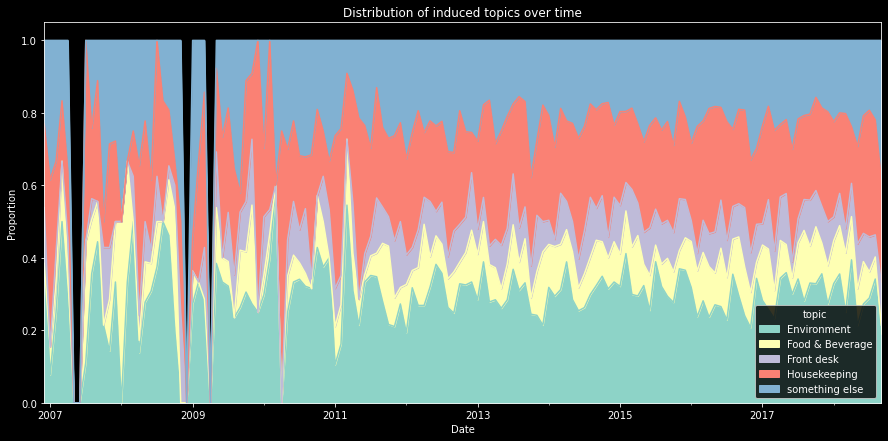

In [46]:
categories.plot(kind='area', title = 'Distribution of induced topics over time', ylabel = 'Proportion', xlabel = 'Date');

It seems the proportion holds through time. While is very noisy. Let's simplify it a bit by just checking the latest year.

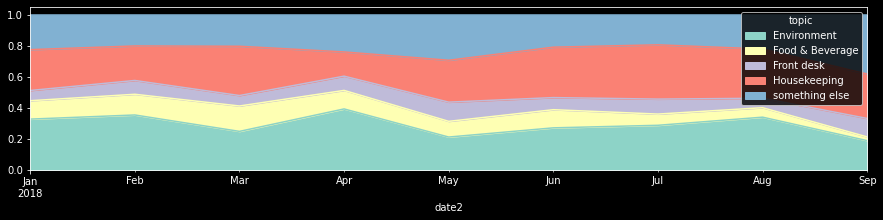

In [47]:
#categories.loc['2014':'2014',:].plot(kind='line',figsize=(12,3))
#categories.loc['2015':'2015',:].plot(kind='line',figsize=(12,3))
#categories.loc['2016':'2016',:].plot(kind='line',figsize=(12,3))
#categories.loc['2017':'2017',:].plot(kind='line',figsize=(12,3))
categories.loc['2018':'2018',:].plot(kind='area',figsize=(15,3));

It seems that something else is becoming more important in comments. But also Housekeeping. Probably should explore that content with other algorithms.

## Other way to classify reviews: LDA

I used word2vec to automatic classify sentences. But there are other options available. For instances, We could do some topic modeling. The standard algorithm is Latent Dirichlet Allocations or LDA, which will cluster sentences in a given number of topics. We have several ways to procced here. 

### Regular LDA

Fist we need to determinate the proper numer of topics. As this is a unsupervised technique, we can only use some heuristics. To do so, I will use perplexiy and coherence score.

In [48]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

common_dictionary = Dictionary(text)
common_corpus = [common_dictionary.doc2bow(i) for i in text]
# the model on the corpus.
lda = LdaModel(common_corpus, id2word = common_dictionary, num_topics = 20)

In [49]:
lda.print_topics()

[(0,
  '0.031*"walk" + 0.029*"beach" + 0.026*"swim" + 0.019*"worth" + 0.018*"apartment" + 0.017*"port_douglas" + 0.017*"long" + 0.014*"half" + 0.013*"hotel" + 0.013*"chose"'),
 (1,
  '0.032*"spent" + 0.031*"great" + 0.019*"pool" + 0.019*"roof_top" + 0.017*"spa" + 0.017*"resort" + 0.016*"family" + 0.014*"sea_temple" + 0.013*"apartment" + 0.012*"big"'),
 (2,
  '0.022*"small" + 0.021*"resort" + 0.021*"room" + 0.018*"week" + 0.015*"excellent" + 0.015*"sit" + 0.014*"relaxed" + 0.013*"wanted" + 0.012*"four" + 0.011*"modern"'),
 (3,
  '0.035*"beach" + 0.022*"found" + 0.020*"could" + 0.019*"hotel" + 0.019*"last" + 0.018*"ordered" + 0.017*"see" + 0.017*"night" + 0.016*"problem" + 0.016*"resort"'),
 (4,
  '0.040*"fantastic" + 0.038*"pool" + 0.024*"studio" + 0.023*"one" + 0.019*"place" + 0.019*"room" + 0.018*"resort" + 0.017*"best" + 0.016*"luxury" + 0.015*"ever"'),
 (5,
  '0.029*"service" + 0.025*"staff" + 0.024*"overall" + 0.019*"great" + 0.018*"experience" + 0.017*"disappointed" + 0.016*"money

In [50]:
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, common_corpus,common_dictionary, mds='tsne');
panel

c:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared 

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8      -10.878068   10.538728       1        1  10.423047
17     -60.884026  -75.591820       2        1   7.535363
18      -2.336119  -53.289074       3        1   6.401966
10     -61.385319  -12.914634       4        1   5.638633
11     -28.737743  126.296997       5        1   5.133207
13       1.066606 -123.552811       6        1   5.078215
7       45.140720   -7.947869       7        1   4.962070
9     -140.795975  -98.530548       8        1   4.833990
0       61.531681  -83.240562       9        1   4.598921
14     -72.563057 -140.396881      10        1   4.538194
4       15.984491   63.578186      11        1   4.451346
6     -160.851624   68.945145      12        1   4.425264
12      85.961830   51.922935      13        1   4.359104
15     -99.020836  109.936348      14        1   4.355649
19    -176.764130   -8.681684      15        1   4.324744
1     -117.189880  -37.420200      16        1   4.179111
5      108.829918  -22.946203      17        1   4.068604
16      47.588097  121.934814      18        1   3.739104
2     -106.467834   30.176889      19        1   3.516731
3      -50.613804   59.328842      20        1   3.436735, topic_info=             Term         Freq        Total Category  logprob  loglift
6            pool  1566.000000  1566.000000  Default  30.0000  30.0000
31          staff   738.000000   738.000000  Default  29.0000  29.0000
8          stayed   740.000000   740.000000  Default  28.0000  28.0000
470          town   338.000000   338.000000  Default  27.0000  27.0000
48         nights   359.000000   359.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
51     sea_temple    34.513934   690.417254  Topic20  -4.2996   0.3747
24   port_douglas    30.187047   582.299580  Topic20  -4.4336   0.4111
77   disappointed    21.503921    89.051209  Topic20  -4.7728   1.9497
238     beautiful    24.589956   340.300211  Topic20  -4.6387   0.7432
27          great    23.610711   702.136603  Topic20  -4.6793  -0.0218

[1286 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
312       1  0.063498            able
312       3  0.349237            able
312       4  0.015874            able
312       5  0.015874            able
312       8  0.063498            able
...     ...       ...             ...
1788      9  0.848129              yo
1919     14  0.959617           young
854       7  0.801804  young_children
854       9  0.114543  young_children
1151      4  0.936154           yummy

[4070 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 18, 19, 11, 12, 14, 8, 10, 1, 15, 5, 7, 13, 16, 20, 2, 6, 17, 3, 4])

In [51]:
from gensim.models import CoherenceModel

cm_lda = CoherenceModel(model=lda, texts=text, dictionary=common_dictionary, coherence='c_v')
cm_lda.get_coherence()

0.3462286664944388

Ok, topics seems to be very well defined (no superpositions), but coherence is very low. Let's try something else like mallet LDA implementation.

In [52]:
import os
os.environ.update({'MALLET_HOME': '..\\mallet-2.0.8\\'})
mallet_path = '..\\mallet-2.0.8\\bin\\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=common_corpus, num_topics=20, id2word=common_dictionary)

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=common_dictionary, 
                                                        corpus=common_corpus, texts=text, 
                                                        start=2, limit=60, step=6)

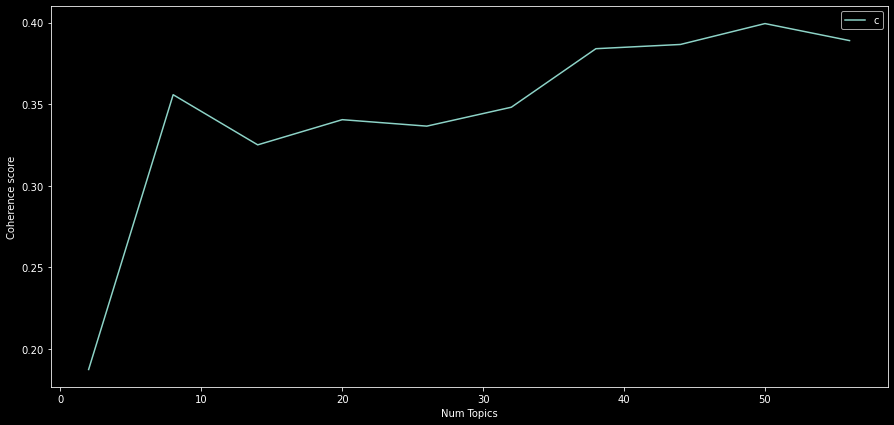

In [54]:
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.pyplot.plot(x, coherence_values)
plt.pyplot.xlabel("Num Topics")
plt.pyplot.ylabel("Coherence score")
plt.pyplot.legend(("coherence_values"), loc='best')
plt.pyplot.show()

In [60]:
pyLDAvis.gensim_models.prepare(model_list[np.argmax(coherence_values)], common_corpus,common_dictionary, mds='tsne')

c:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared 

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
30    -105.397438  -45.189461       1        1  3.894255
49     -77.066338  -77.598122       2        1  3.309465
27      20.411186   68.965477       3        1  2.941533
36    -103.980125 -106.872078       4        1  2.906918
17     -76.202538  -40.814522       5        1  2.733177
22     123.099037  -64.855347       6        1  2.721563
3      115.717896   51.829056       7        1  2.624230
6       95.019829  -44.946980       8        1  2.466545
35     -15.491901 -125.642670       9        1  2.386800
23      73.784767  -84.457077      10        1  2.367718
18      -9.735615   77.371765      11        1  2.366370
42     -69.253830   -7.898070      12        1  2.340544
9      127.013626  -18.544937      13        1  2.331739
45      93.136040   62.438530      14        1  2.276141
4      164.657852   52.644516      15        1  2.209343
34    -128.402557   21.957010      16        1  2.115966
44     -88.743523   24.901972      17        1  2.078488
41     -48.042439  -84.336693      18        1  2.041282
1      102.973732   -3.625441      19        1  2.034515
10     103.623573  -93.989113      20        1  2.009200
37      45.802849   50.908100      21        1  1.982338
20     -29.709936   53.968597      22        1  1.975060
12      66.393600  -17.573513      23        1  1.968545
5       64.551163  -51.210716      24        1  1.948797
39     -88.194527   65.614235      25        1  1.941001
38     -18.480545   22.403240      26        1  1.939038
43     -48.124050    9.062307      27        1  1.925228
48     -51.200443   77.513474      28        1  1.855614
29     -49.828533  -38.302616      29        1  1.809871
7      -17.009726  118.938591      30        1  1.809619
19     105.677773  118.946274      31        1  1.738630
14      35.110004  110.676643      32        1  1.724895
40      32.607891   -1.826533      33        1  1.721708
26     -29.117376  158.633713      34        1  1.709629
15       6.082222   -5.123960      35        1  1.706485
24    -150.296524  -23.668991      36        1  1.648091
47     -79.488121  146.011902      37        1  1.630123
2      -61.741432  113.207336      38        1  1.575276
0       17.166260   28.929291      39        1  1.570917
21      67.748039   86.592224      40        1  1.562500
46    -114.865257  109.574127      41        1  1.519082
16      23.375656  -92.714638      42        1  1.504409
33     -11.624422  -59.885338      43        1  1.495847
28      67.125954   21.941668      44        1  1.479057
32    -102.173241  -14.829350      45        1  1.418575
31      20.272394  -38.372871      46        1  1.395116
8       21.727091  148.596420      47        1  1.354688
11     -22.587658  -21.005518      48        1  1.320250
13     -58.997177   41.200745      49        1  1.315771
25    -133.782928   65.077629      50        1  1.298045, topic_info=           Term         Freq        Total Category  logprob  loglift
6          pool  1602.000000  1602.000000  Default  30.0000  30.0000
31        staff   776.000000   776.000000  Default  29.0000  29.0000
51   sea_temple   678.000000   678.000000  Default  28.0000  28.0000
130    friendly   338.000000   338.000000  Default  27.0000  27.0000
178     bedroom   426.000000   426.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
165      little    13.060179   200.116999  Topic50  -4.2978   1.6150
50       resort    18.127643  1031.443385  Topic50  -3.9699   0.3030
131       rooms    14.270012   423.742068  Topic50  -4.2092   0.9533
345        good    13.510690   451.240792  Topic50  -4.2639   0.8358
427      people    10.432063   122.221890  Topic50  -4.5225   1.8834

[2570 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
312       9  0.770783            able
312      17  

These topic makes a lot of sense now, use better the space.

The fisrt one is about the swiming pool, the rest is about

# Sentiment analysis

So far I have seen how frequently each section got named, but I don't have idea if it is positive or negative. As most reviews give a high score to the resort we could asumme that most comments are positive, but its not necessary. To do these we could use pre-build polarity sentiment models.

In [226]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def nltk_sentiment(sentence):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [227]:
nltk_results = data_sentence.sentence.apply(nltk_sentiment)
results_df = pd.DataFrame(nltk_results.tolist())
#text_df = pd.DataFrame(dataset, columns = ['text'])
data_sentiment = data_sentence.join(results_df)

data_sentiment.set_index(pd.DatetimeIndex(data_sentiment['date2']), inplace=True)
data_sentiment = data_sentiment.sort_index()

### Global sentiment by category

<AxesSubplot:title={'center':'compound'}, xlabel='[topic]'>

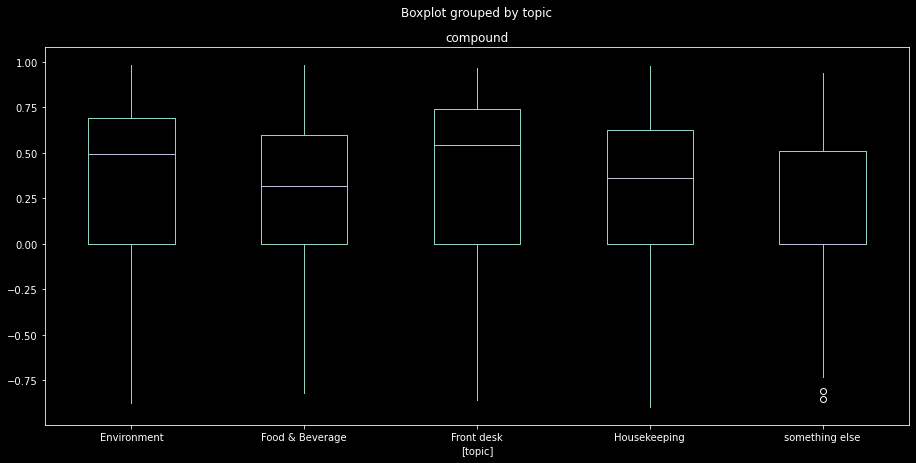

In [230]:
data_sentiment[['topic', 'compound']].boxplot(by='topic',grid=False)

### Sentiment by time and category

In [179]:
sen = pd.pivot_table(data_sentiment, values='compound', index=data_sentiment.index, columns=['topic'], aggfunc=np.mean)
sen = sen.resample(rule='M').mean()

C:\Users\framo\AppData\Local\Temp/ipykernel_14216/1096954557.py:1: UserWarning: Parsing '31/12/2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sen[sen.index>pd.to_datetime("31/12/2013")].plot(kind='line')


<AxesSubplot:xlabel='date2'>

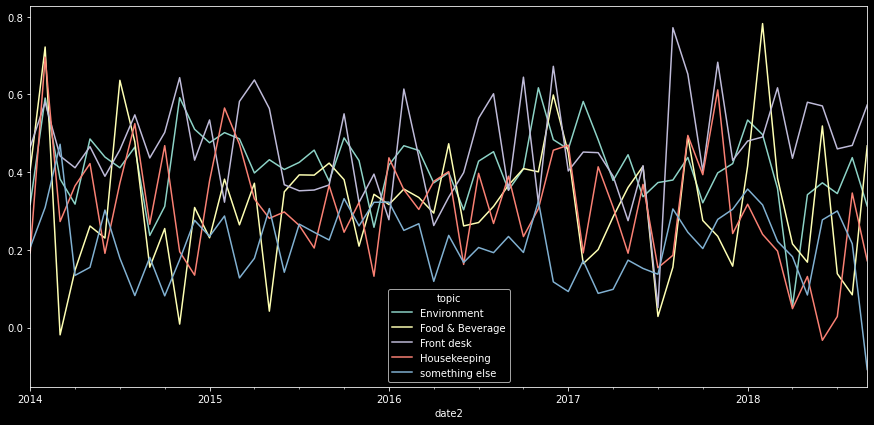

In [180]:
sen[sen.index>pd.to_datetime("31/12/2013")].plot(kind='line')

<AxesSubplot:xlabel='date2'>

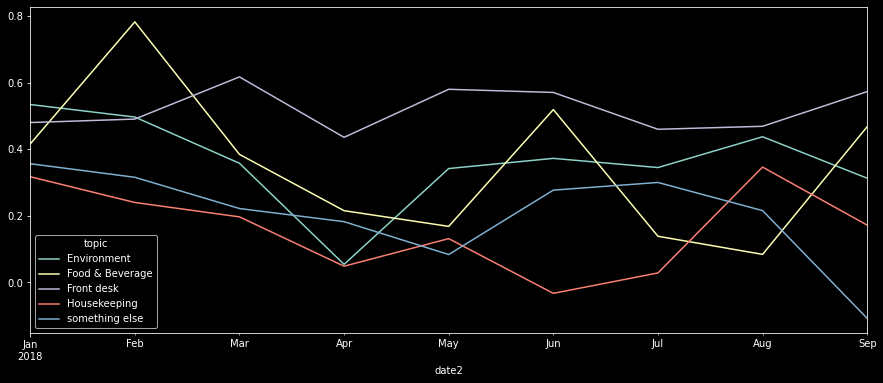

In [181]:
#sen.loc['2014':'2014',:].plot(kind='line', figsize=(12,3))
#sen.loc['2015':'2015',:].plot(kind='line', figsize=(12,3),legend=False)
#sen.loc['2016':'2016',:].plot(kind='line', figsize=(12,3))
#sen.loc['2017':'2017',:].plot(kind='line', figsize=(12,3),legend=False)
sen.loc['2018':'2018',:].plot(kind='line', figsize=(15,6))

Positive sentiments are more likely for every aspect but the most important takeaway here is variation. Both graphs show a lot of noise. Let's clear it out a bit.

### Seasonal Decomposition

C:\Users\framo\AppData\Local\Temp/ipykernel_14216/1510378820.py:2: UserWarning: Parsing '31/12/2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  serie = sen[sen.index>pd.to_datetime("31/12/2013")]


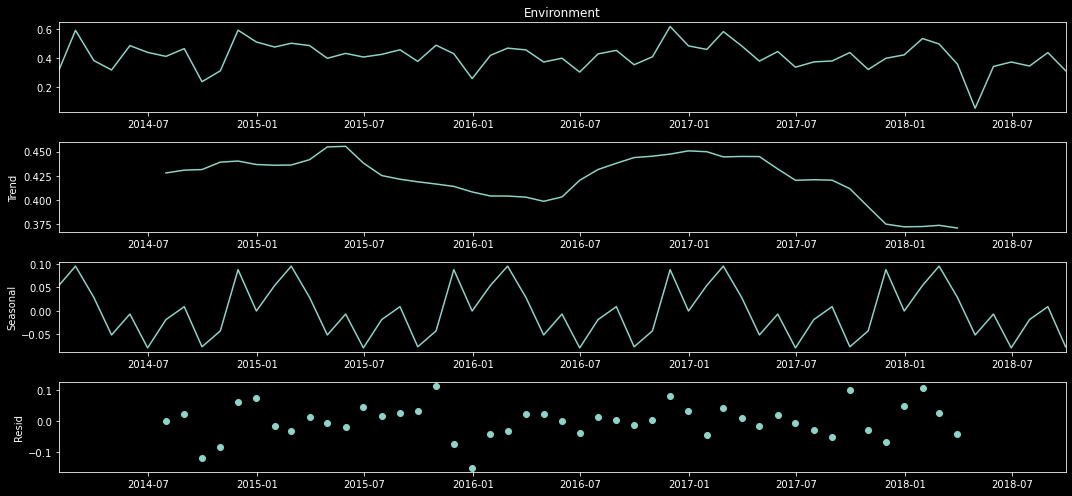

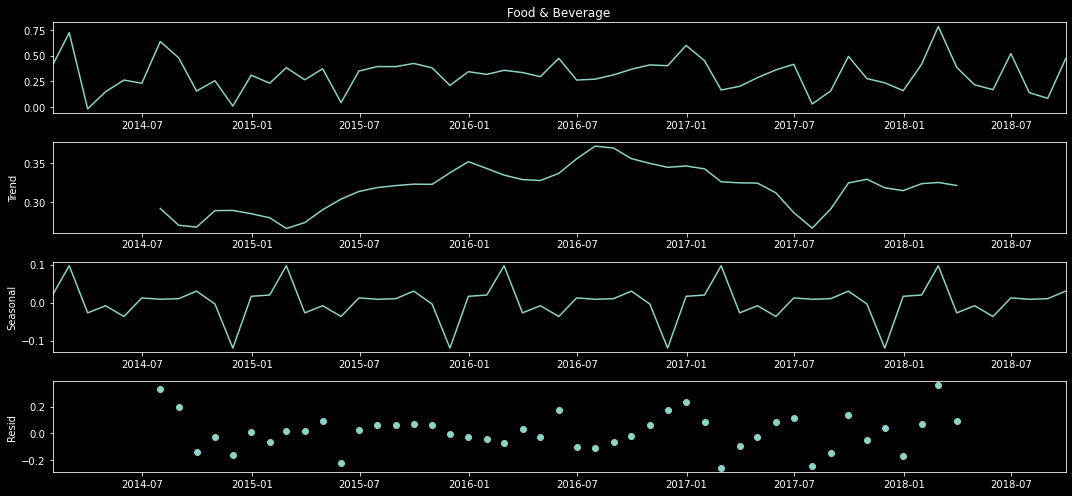

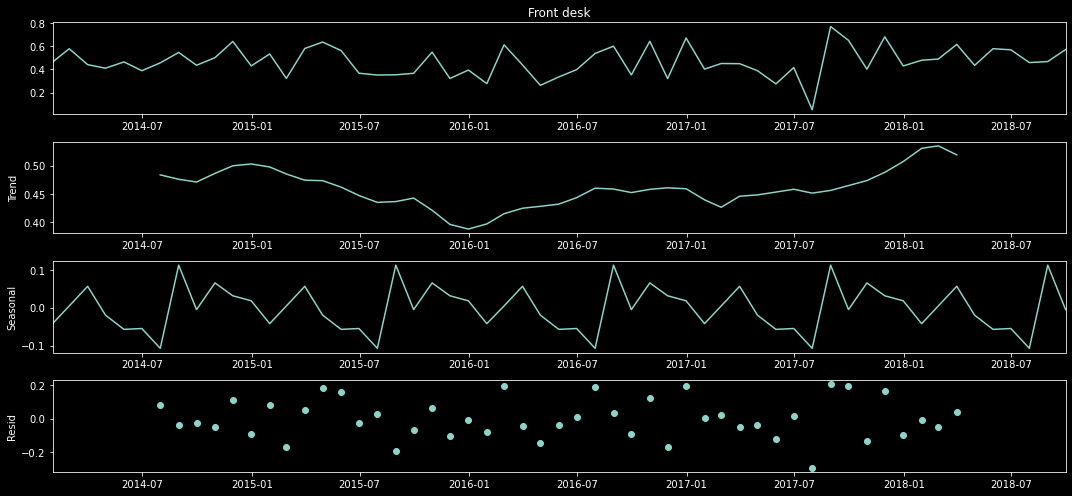

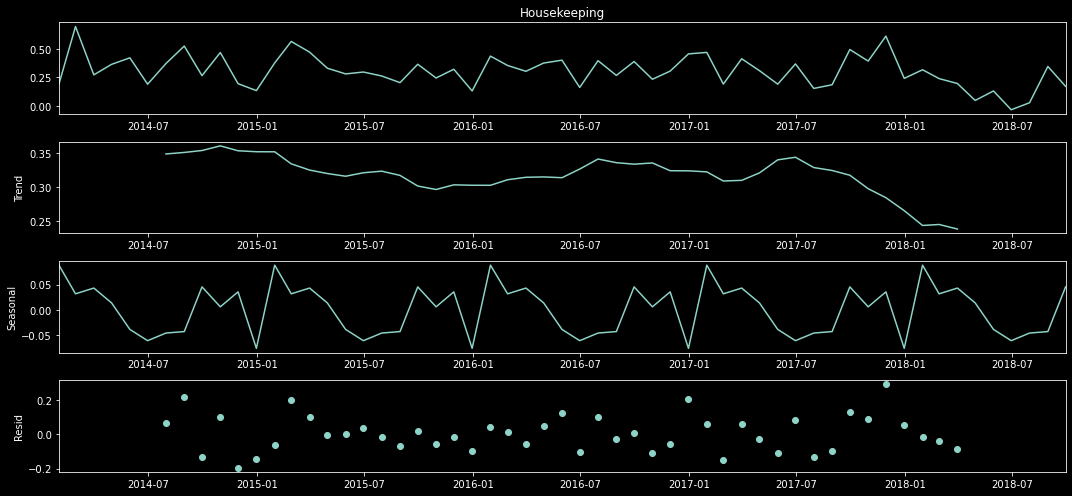

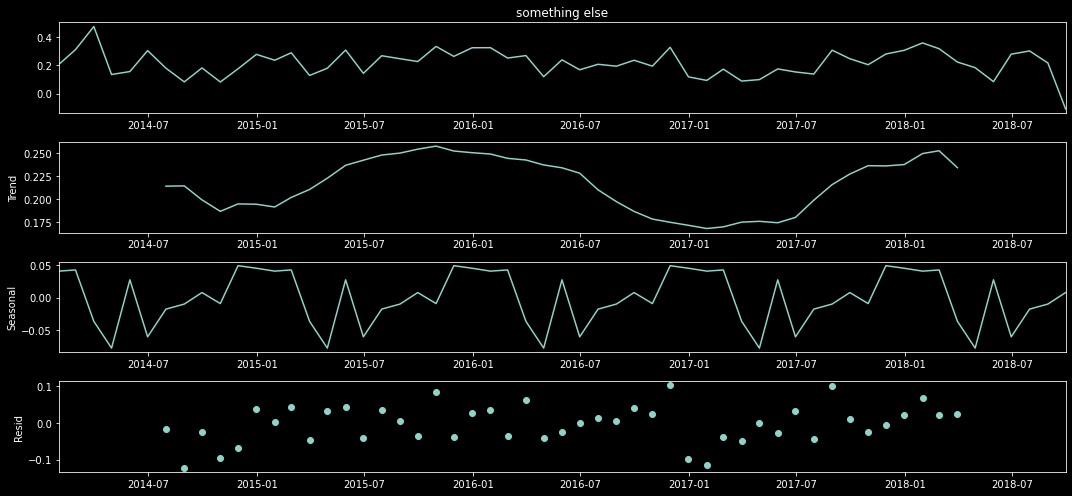

In [182]:
from statsmodels.tsa.seasonal import seasonal_decompose
serie = sen[sen.index>pd.to_datetime("31/12/2013")]
for i in sen.columns:
    result = seasonal_decompose(serie[i], model='additive')
    result.plot()


OK, this looks interesting. Sentiment are seasonal and doesn't show a trend. Except for "Enviroment," which is becoming more and more negative. It kind of makes sense that Enviromnent get lower score over time as infraestructure becomes old and regular customers get used to, for instance, the pool. It doesn't plays an important part of their experience any more.

In the other hand, housekeeping is very seasonal (very positive at the begining of the year, flat the rest of the year.

## Validation

Finally, we can validate these results by comparing them to the scores given by the user next to the comments

In [231]:
data_sentence.columns

Index(['sentence', 'title', 'score', 'comment', 'date', 'new_col', 'keywords',
       'topic', 'probability', 'date2'],
      dtype='object')

In [235]:
data_sentence[['score', 'topic', 'sentence', 'comment']]

,score,topic,sentence,comment
0,3.0,something else,star prices star service,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
1,3.0,Housekeeping,stayed villa private pool ok needs updating looks tired,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
2,3.0,Environment,maintenance man even said hard keep hotels issues,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
3,3.0,something else,food bang average hotel round port_douglas,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
4,3.0,Housekeeping,staff great try make stay nice fault think hotel run,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
...,...,...,...,...
9531,4.0,something else,manager told yes know worth get,"This is a great resort if you like luxurious living. The rooms were nice (and we only got a studio), very comfortable bed, awesome jacuzzi bathtub and great pool. Service was surprisingly good, since we'd heard some bad things prior to coming. Very accomodating staff. You also get your own little garage for your car. The negatives, they provide robes which is like putting sandpaper to your skin, there are sugar ants that may invade your room in the summer (which they do give you spray for if you get them - we had them just one night). Limited menu if you're a vegetarian (so just go into ""town"") and lastly, this place is in the middle of NO WHERE. Off the main street, there's one sign to turn and then no others... we found the golf club and had to go ask where to go from there... they do not make it easy to find. (The manager told me ""Yes, I know, but it's worth it once you get there."" hmmmm.) All in all a great value for the $$$ - we'd go back."
9532,4.0,something else,hmmmm,"This is a great resort if you like luxurious living. The rooms were nice (and we only got a studio), very comfortable bed, awesome jacuzzi bathtub and great pool. Service was surprisingly good, since we'd heard some bad things prior to coming. Very accomodating staff. You also get your own little garage for your car. The negatives, they provide robes which is like putting sandpaper to your skin, there are sugar ants that may invade your room in the summer (which they do give you spray for if you get them - we had them just

## Conclusions

We can summarise the main take away as:

- Seasonality put crate pressure over both Food and beverage and Housekeeping
- It is important to considere that one of the most important features of the PPD is the swiming pool and other enviromental and infrastructure factors, and those may need renewal

There are many more thing that can be done with this dataset. we could go deeper with the topics and try to identify subtopics. Create a regression to identifyt factors affecting the overall score